# Traffic and Congestion Analysis
---
dataset date range:
- end date 2018-06-01
- start date 2018-05-01

In [17]:
#!pip install seaborn
#!pip uninstall matplotlib
#!pip install matplotlib==3.7.3
!pip show seaborn
!pip show matplotlib

Name: seaborn
Version: 0.13.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: c:\users\megan\anaconda3\envs\taxidev\lib\site-packages
Requires: matplotlib, numpy, pandas
Required-by: 
Name: matplotlib
Version: 3.7.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\users\megan\anaconda3\envs\taxidev\lib\site-packages
Requires: contourpy, cycler, fonttools, importlib-resources, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: seaborn


In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Temporal Pattern Analysis
Analyze temporal patterns to identify peak hours and days.

In [29]:
# Set the date range
end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Convert pickup datetime to pandas datetime format
nyc_tlc_df['lpepPickupDatetime'] = pd.to_datetime(nyc_tlc_df['lpepPickupDatetime'])

# Extract hour and day of the week from the pickup datetime
nyc_tlc_df['hour'] = nyc_tlc_df['lpepPickupDatetime'].dt.hour
nyc_tlc_df['day_of_week'] = nyc_tlc_df['lpepPickupDatetime'].dt.day_name()

# Extract month and year from the pickup datetime
nyc_tlc_df['month'] = nyc_tlc_df['lpepPickupDatetime'].dt.month.astype(str)
nyc_tlc_df['year'] = nyc_tlc_df['lpepPickupDatetime'].dt.year.astype(str)

# Compute trip duration in minutes
nyc_tlc_df['tripDuration'] = (nyc_tlc_df['lpepDropoffDatetime'] - nyc_tlc_df['lpepPickupDatetime']).dt.total_seconds() / 60.0

# Define trip length categories
bins = [0, 1, 2, 5, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
nyc_tlc_df['trip_length_category'] = pd.cut(nyc_tlc_df['tripDistance'], bins=bins, labels=labels, right=False)

nyc_tlc_df['trip_duration_category'] = pd.cut(nyc_tlc_df['tripDuration'], bins=bins, labels=labels, right=False)

nyc_tlc_df.head()

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from C:\Users\Megan\AppData\Local\Temp\tmprq3qeazj\https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2018/puMonth=5/part-00087-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2657-1.c000.snappy.parquet
[Info] read from C:\Users\Megan\AppData\Local\Temp\tmprq3qeazj\https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2018/puMonth=6/part-00171-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2741-1.c000.snappy.parquet


,vendorID,lpepPickupDatetime,lpepDropoffDatetime,passengerCount,tripDistance,puLocationId,doLocationId,pickupLongitude,pickupLatitude,dropoffLongitude,...,ehailFee,totalAmount,tripType,hour,day_of_week,month,year,tripDuration,trip_length_category,trip_duration_category
0,2,2018-05-18 20:32:54,2018-05-18 21:08:10,1,6.73,74,107,NaN,NaN,NaN,...,NaN,27.3,1,20,Friday,5,2018,35.266667,5-10,30-40
1,2,2018-05-25 20:16:31,2018-05-25 20:20:07,1,0.51,166,166,NaN,NaN,NaN,...,NaN,5.3,1,20,Friday,5,2018,3.600000,0-1,2-5
2,2,2018-05-25 20:26:02,2018-05-25 20:41:01,1,2.60,166,75,NaN,NaN,NaN,...,NaN,12.8,1,20,Friday,5,2018,14.983333,2-5,10-20
3,2,2018-05-25 20:45:36,2018-05-25 21:04:26,1,3.04,75,152,NaN,NaN,NaN,...,NaN,14.3,1,20,Friday,5,2018,18.833333,2-5,10-20
4,2,2018-05-15 14:05:40,2018-05-15 14:17:53,1,1.60,116,243,NaN,NaN,NaN,...,NaN,10.8,1,14,Tuesday,5,2018,12.216667,1-2,10-20


In [30]:
# Group by hour
hourly_usage = nyc_tlc_df.groupby('hour').size()

# Group by day of the week
daily_usage = nyc_tlc_df.groupby('day_of_week').size()
daily_usage = daily_usage.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Group by month
monthly_usage = nyc_tlc_df.groupby('month').size()

# Group by year
yearly_usage = nyc_tlc_df.groupby('year').size()

# Group by day of the week and hour
heatmap_data = nyc_tlc_df.groupby(['day_of_week', 'hour']).size().unstack().reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

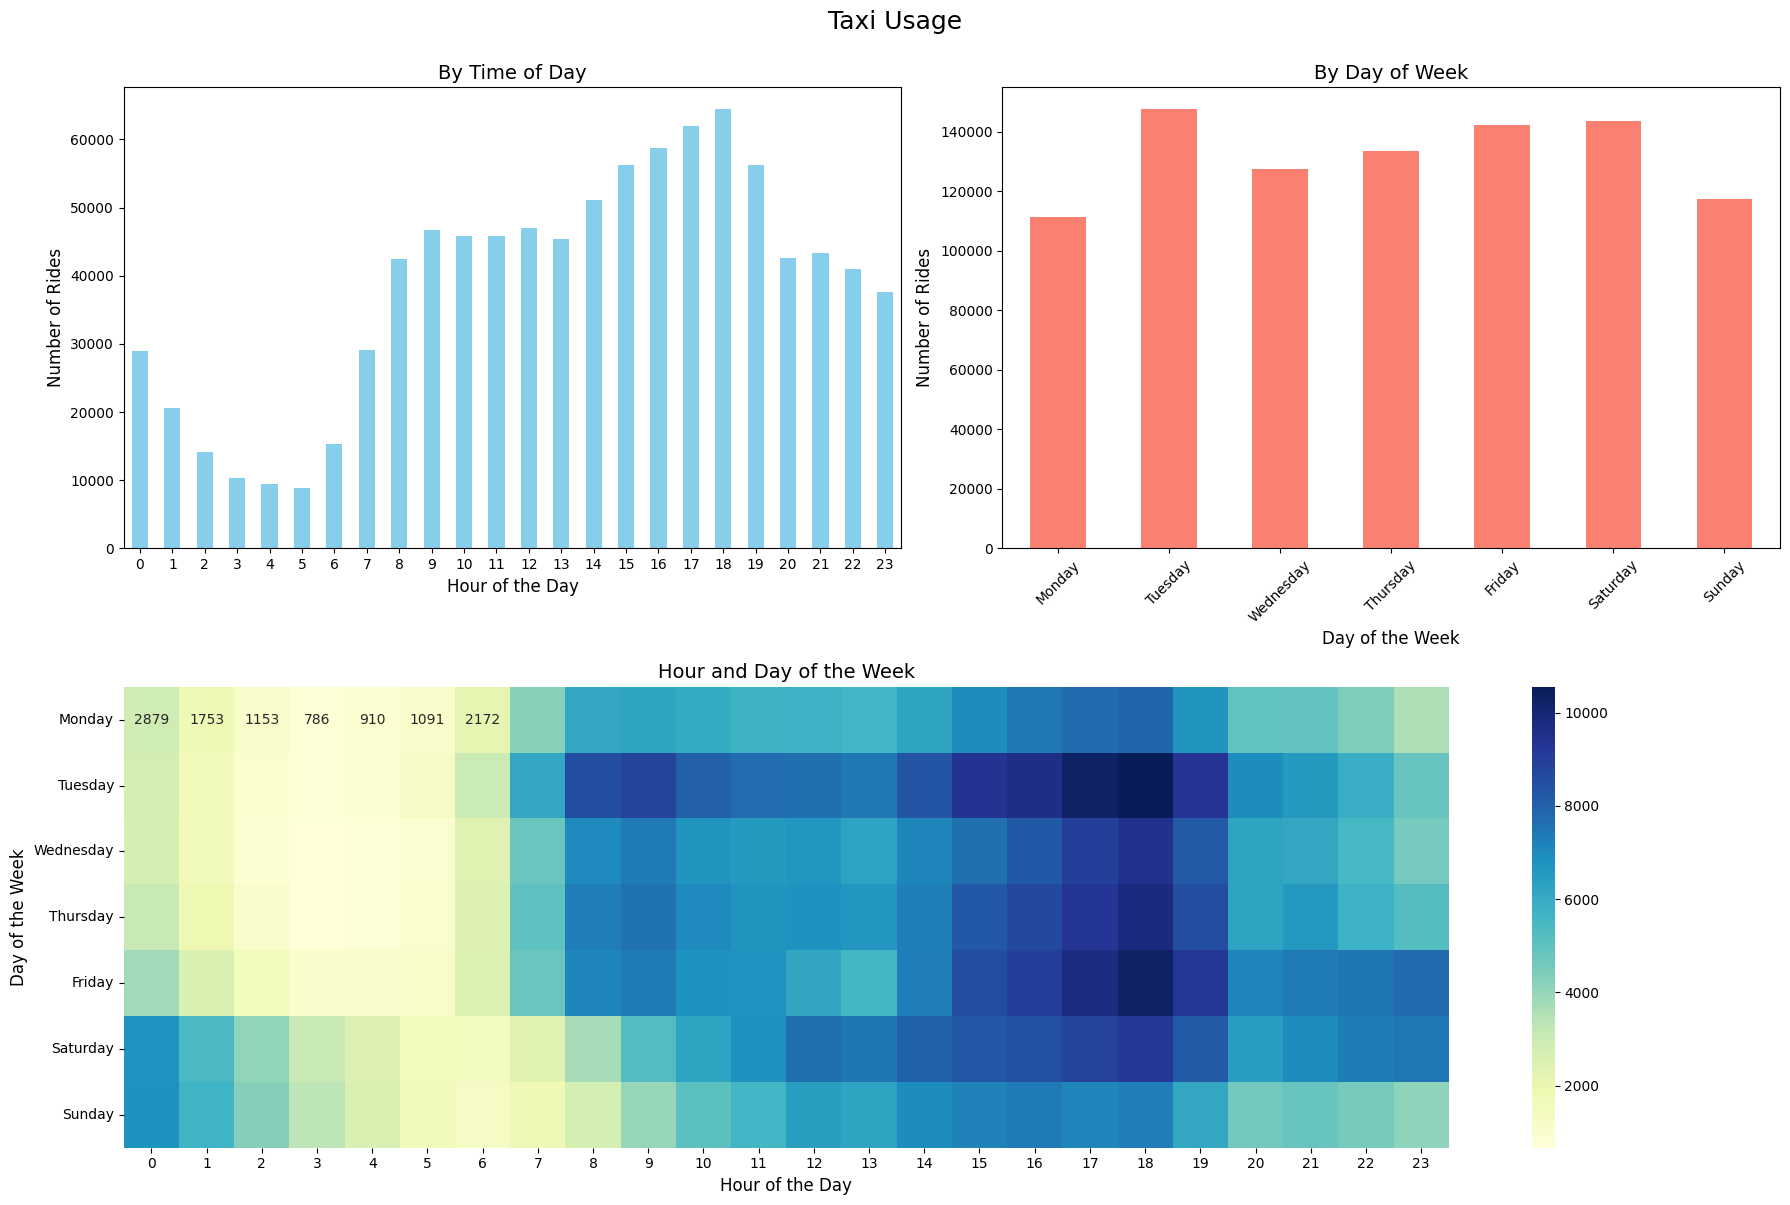

In [34]:
# Plot the results
plt.figure(figsize=(18, 12))

# Plot hourly usage
plt.subplot(2, 2, 1)
hourly_usage.plot(kind='bar', color='skyblue')
plt.title('By Time of Day', size=14)
plt.xlabel('Hour of the Day', size=12)
plt.ylabel('Number of Rides', size=12)
plt.xticks(rotation=0)

# Plot daily usage
plt.subplot(2, 2, 2)
daily_usage.plot(kind='bar', color='salmon')
plt.title('By Day of Week', size=14)
plt.xlabel('Day of the Week', size=12)
plt.ylabel('Number of Rides', size=12)
plt.xticks(rotation=45)

# Plot monthly usage
#plt.subplot(3, 2, 3)
#monthly_usage.plot(kind='bar', color='mediumseagreen')
#plt.title('Taxi Usage by Month')
#plt.xlabel('Month')
#plt.ylabel('Number of Rides')
#plt.xticks(rotation=0)

# Plot yearly usage
#plt.subplot(3, 2, 4)
#yearly_usage.plot(kind='bar', color='thistle')
#plt.title('Taxi Usage by Year')
#plt.xlabel('Year')
#plt.ylabel('Number of Rides')
#plt.xticks(rotation=45)

# Plot heat map
plt.subplot(2, 1, 2)
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Hour and Day of the Week', size=14)
plt.xlabel('Hour of the Day', size=12)
plt.ylabel('Day of the Week', size=12)

plt.suptitle('Taxi Usage', y=1, fontsize=18)
plt.tight_layout()
plt.show()

**Discussion of Analysis** ADD ANALYSIS

 ## Ride Durations Analysis
 Calculate ride durations and their variation.

In [22]:
# Group by hour
hourly_df = nyc_tlc_df.groupby('hour').mean()

# Group by day of the week
daily_df = nyc_tlc_df.groupby('day_of_week').mean()

# Group by month
monthly_df = nyc_tlc_df.groupby('month').mean()

# Group by year
yearly_df = nyc_tlc_df.groupby('year').mean()

# Group by day of the week and hour
hm_subset = nyc_tlc_df[['tripDuration', 'day_of_week', 'hour']]
heatmap_df = hm_subset.groupby(['day_of_week', 'hour']).mean().unstack().reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)
hm_tripDuration_df = heatmap_df['tripDuration']

# Subset each dataframe for the tripDistance column for plots
hourly_tripDuration_avg = hourly_df[['tripDuration']]
daily_tripDuration_avg = daily_df[['tripDuration']]
monthly_tripDuration_avg = monthly_df[['tripDuration']]
yearly_tripDuration_avg = yearly_df[['tripDuration']]

average trip duration: 23.0


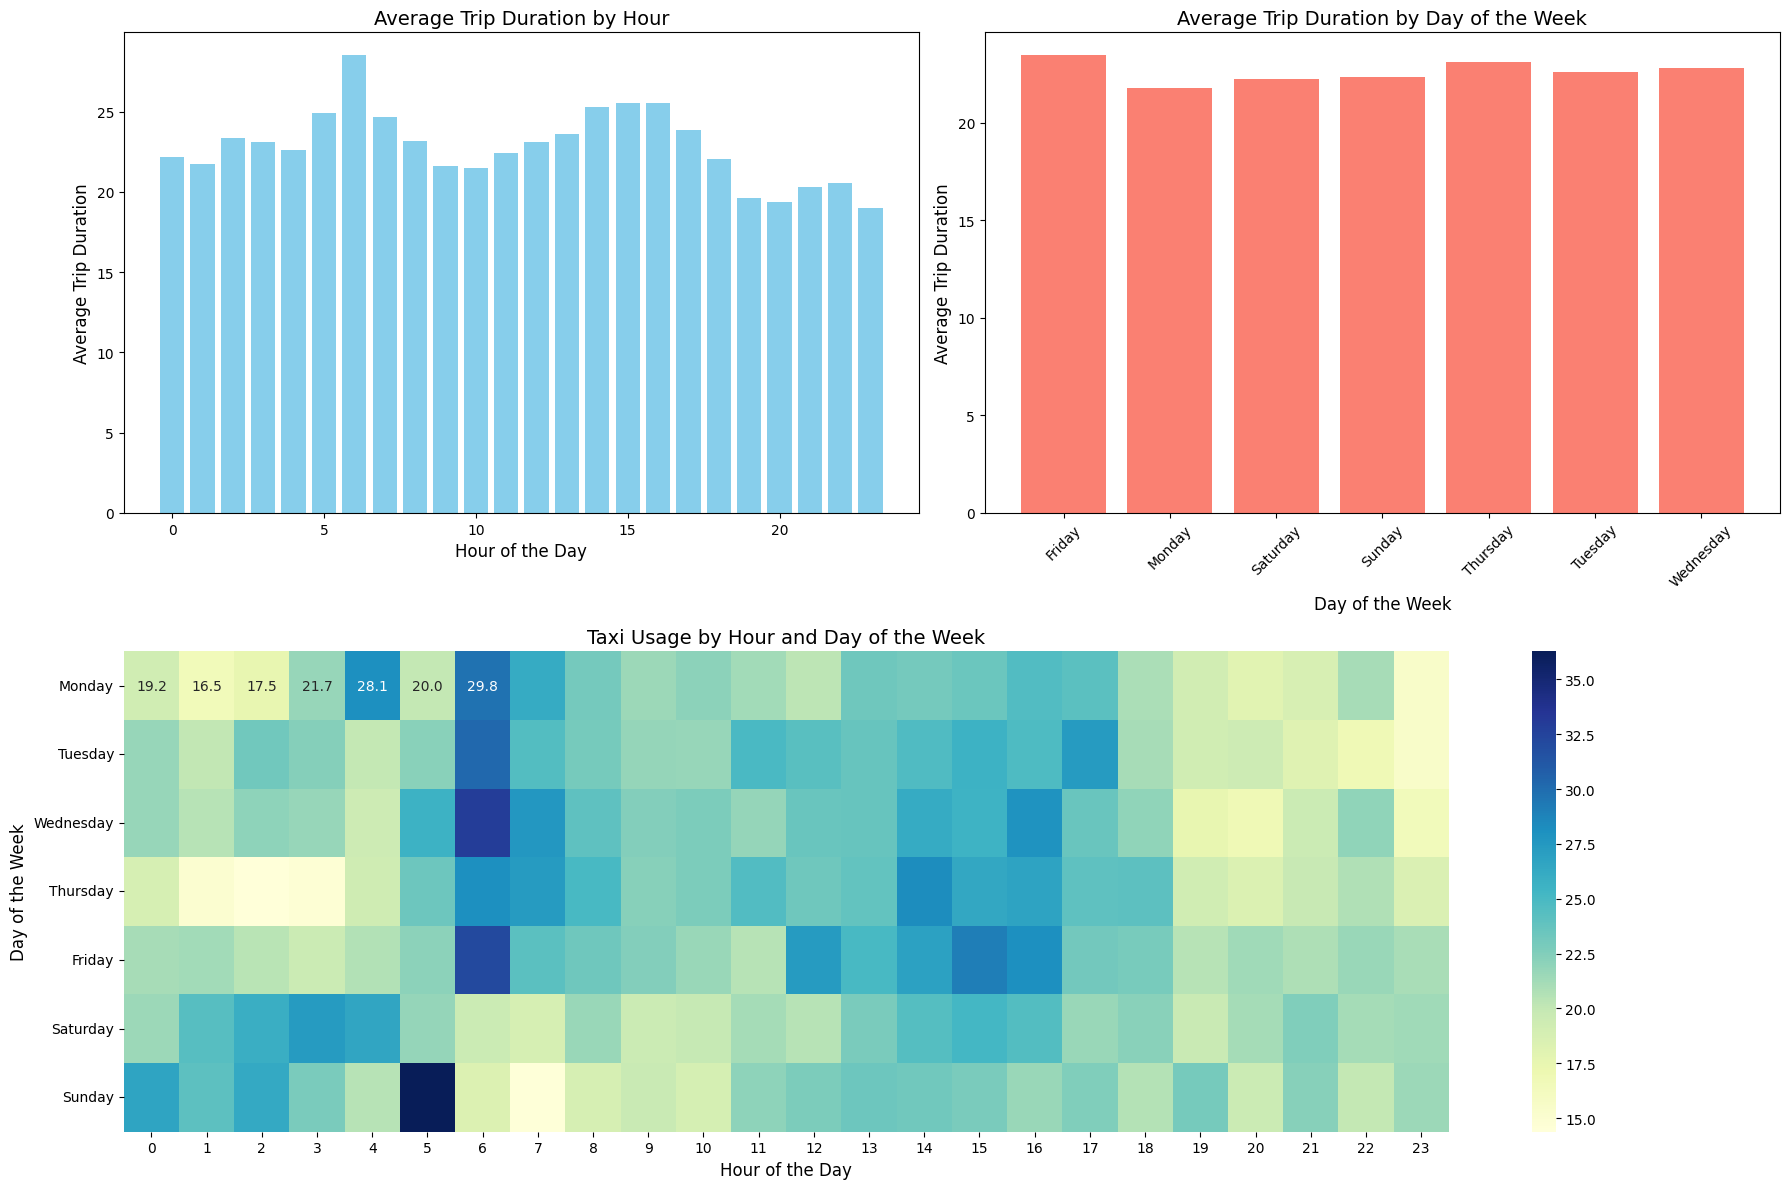

In [26]:
print(f"average trip duration: {round(nyc_tlc_df['tripDuration'].mean(),0)}")
#print(f"median trip duration: {round(nyc_tlc_df['tripDuration'].median(),0)}")

# Plot the results
plt.figure(figsize=(18, 12))

# Plot hourly usage
plt.subplot(2, 2, 1)
plt.bar(hourly_tripDuration_avg.index.values, hourly_tripDuration_avg['tripDuration'], color='skyblue')
plt.title('Average Trip Duration by Hour', size=14)
plt.xlabel('Hour of the Day', size=12)
plt.ylabel('Average Trip Duration', size=12)
plt.xticks(rotation=0)

# Plot daily usage
plt.subplot(2, 2, 2)
plt.bar(daily_tripDuration_avg.index.values, daily_tripDuration_avg['tripDuration'], color='salmon')
plt.title('Average Trip Duration by Day of the Week', size=14)
plt.xlabel('Day of the Week', size=12)
plt.ylabel('Average Trip Duration', size=12)
plt.xticks(rotation=45)

# Plot monthly usage
#plt.subplot(2, 2, 3)
#plt.bar(monthly_tripDistance_avg.index.values, monthly_tripDistance_avg['tripDistance'], color='mediumseagreen')
#plt.title('Average Trip Distance by Month')
#plt.xlabel('Month')
#plt.ylabel('Average Trip Distance')
#plt.xticks(rotation=0)

# Plot yearly usage
#plt.subplot(2, 2, 4)
#plt.bar(yearly_tripDistance_avg.index.values, yearly_tripDistance_avg['tripDistance'], color='thistle')
#plt.title('Average Trip Distance by Year')
#plt.xlabel('Year')
#plt.ylabel('Average Trip Distance')
#plt.xticks(rotation=45)

# Plot heat map
plt.subplot(2, 1, 2)
sns.heatmap(hm_tripDuration_df, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Taxi Usage by Hour and Day of the Week', size=14)
plt.xlabel('Hour of the Day', size=12)
plt.ylabel('Day of the Week', size=12)

plt.tight_layout()
plt.show()



**Discussion of Analysis** Average trip duartion is around 23 mintues. During the work week, 6 in the morning has the longest trip durations and then in the afternoon, trip duratioin begins to pickup between 2 and 4. 

## Traffic Intensity
Analyze pickup and drop off location by borough and zone by looking at trip distance and duration.

In [312]:
# Import data on the Taxi Location Codes
zones_df = pd.read_csv('References/taxi_zones.csv')
zones_df['LocationID'] = zones_df['LocationID'].astype('str')

zones = zones_df.drop_duplicates(subset=['LocationID'])

In [329]:
# Create a subset of original dataset that include date and time information, trip distance, location information, and trip type
zone_taxi_df = nyc_tlc_df[['lpepPickupDatetime', 'lpepDropoffDatetime', 'passengerCount', 'tripDistance', 
                           'puLocationId', 'doLocationId', 'tripType', 'hour', 'day_of_week', 'month', 'year']]

In [310]:
# Add columns that identify the zone and borough of the pick up location
pu_zones = zones.rename(columns={'LocationID': 'puLocationId'})
zone_loc_df = zone_taxi_df.merge(pu_zones, how='left', on='puLocationId').reindex(columns=['lpepPickupDatetime', 'lpepDropoffDatetime', 'passengerCount', 'tripDistance', 'puLocationId', 'zone', 'borough', 'doLocationId', 'tripType', 'hour', 'day_of_week', 'month', 'year'])
# Rename pickup zone and borough to be unique
zone_loc_df = zone_loc_df.rename(columns={'zone': 'puZone', 'borough': 'puBorough'})

# Add columns that identify the zone and borough of the drop off location
do_zones = zones.rename(columns={'LocationID': 'doLocationId'})
zone_loc_df = zone_loc_df.merge(do_zones, how='left', on='doLocationId').reindex(columns=['lpepPickupDatetime', 'lpepDropoffDatetime', 'passengerCount', 'tripDistance', 'puLocationId', 'puZone', 'puBorough', 'doLocationId', 'zone', 'borough', 'tripType', 'hour', 'day_of_week', 'month', 'year'])
# Rename pickup zone and borough to be unique
zone_loc_df = zone_loc_df.rename(columns={'zone': 'doZone', 'borough': 'doBorough'})

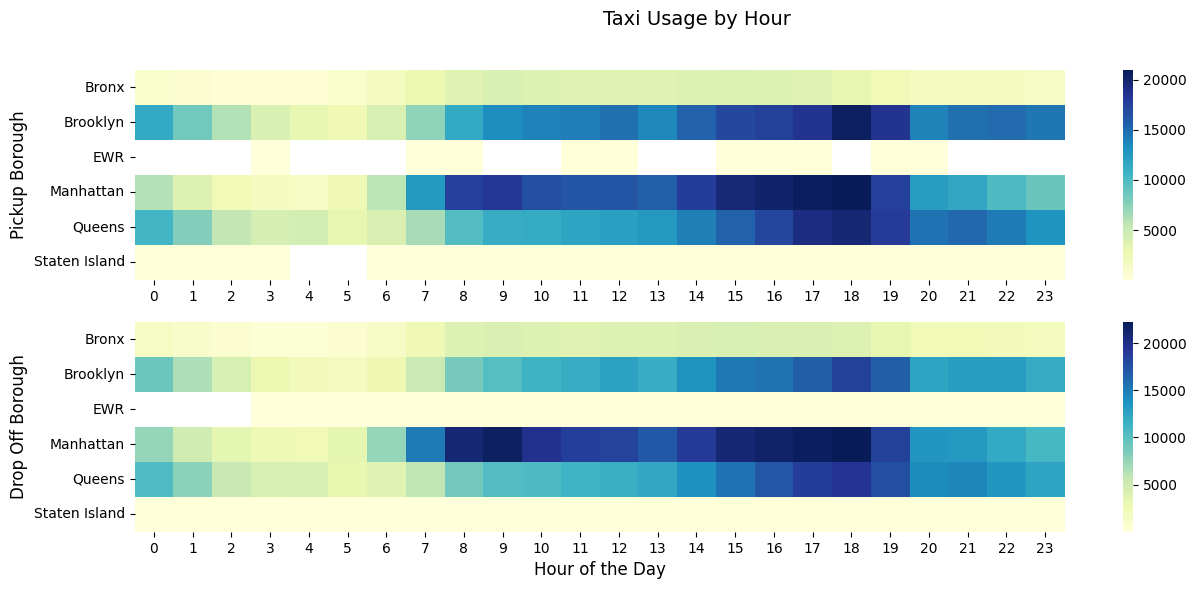

In [328]:
puB_loc_df = zone_loc_df.groupby(['puBorough', 'hour']).size().unstack()
doB_loc_df = zone_loc_df.groupby(['doBorough', 'hour']).size().unstack()

# Plot heatmap of pickup location
#fig, (ax1, ax2) = plt.subplots(4, 1, sharex=True, figsize=(15,6))

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
sns.heatmap(puB_loc_df, cmap='YlGnBu', annot=False).set(xlabel=None)
plt.ylabel('Pickup Borough', size=12)

plt.subplot(2, 1, 2)
sns.heatmap(doB_loc_df, cmap='YlGnBu', annot=False)
plt.ylabel('Drop Off Borough', size=12)
plt.xlabel('Hour of the Day', size=12)

plt.suptitle("Taxi Usage by Hour", fontsize=14)
plt.show()

**Discussion of Analysis** Brooklyn, Manhattan, and Queens have high trip numbers compared to the the other boroughs for both drop offs and pickups, with Manhattan being the busiest. Demand begins to increase around 7 and peaks around 18 and then begin to slowly calm down. In Manhattan, there are 2 peaks in demand, one in the morning at 9 and another at 18 for both drop offs and pickups.

In [311]:
# Create a dataframe with the pickup and drop off locations mapped to one another
mapped_boroughs = zone_loc_df.copy()
mapped_boroughs['mapped'] = mapped_boroughs['puBorough'] + " to " + mapped_boroughs['doBorough']

map_diffBorough = []

for i in range(0, len(mapped_boroughs)):
    if(mapped_boroughs['puBorough'][i] == mapped_boroughs['doBorough'][i]):
        map_diffBorough.append(mapped_boroughs['puBorough'][i])
    else:
        map_diffBorough.append(mapped_boroughs['mapped'][i])
    
mapped_boroughs['map_diffBorough'] = map_diffBorough

In [253]:
# Number of trips between boroughs and within boroughs
borough_trips = mapped_boroughs.groupby('map_diffBorough').size()

# Length of trip between and within boroughs
borough_trip_length = mapped_boroughs.groupby(['day_of_week','map_diffBorough'])['tripDistance'].mean().unstack().reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).dropna(1)

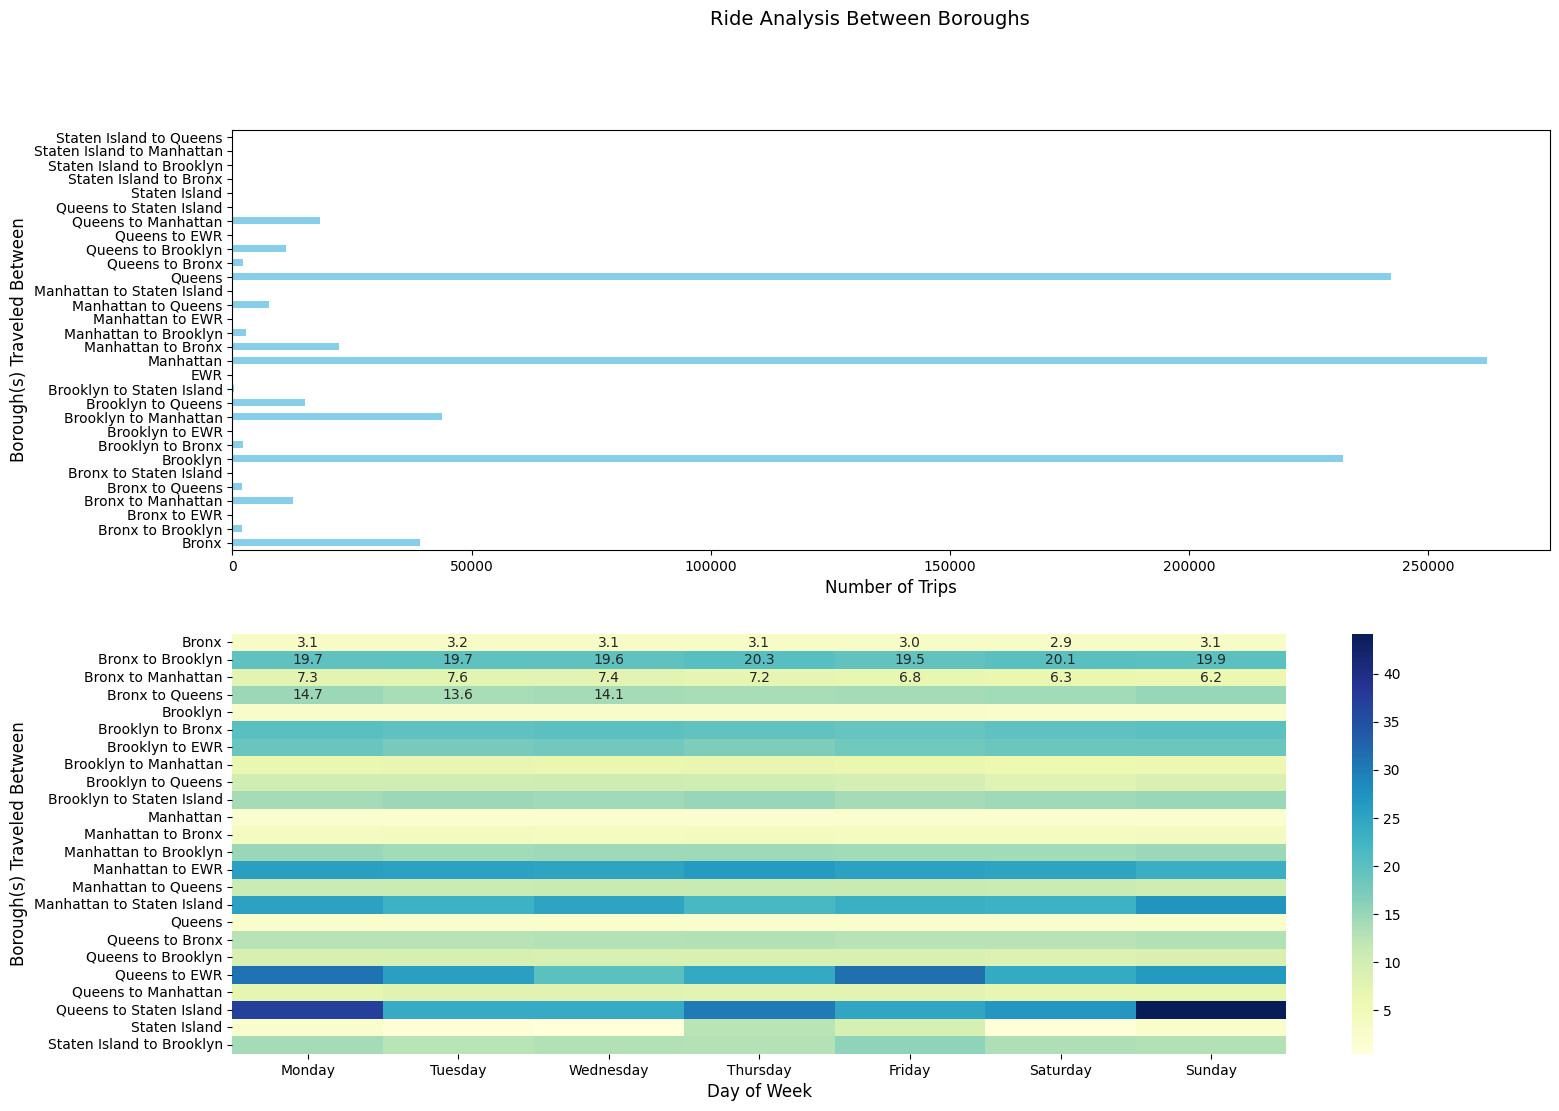

In [325]:
# Plot ride analysis of number of trips between boroughs and average trip length on different days of the week
plt.figure(figsize=(17, 12))

plt.subplot(2, 1, 1)
borough_trips.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Trips', size=12)
plt.ylabel('Borough(s) Traveled Between', size=12)

plt.subplot(2, 1, 2)
sns.heatmap(borough_trip_length.transpose(), cmap='YlGnBu', annot=True, fmt='.1f')
plt.xlabel('Day of Week', size=12)
plt.ylabel('Borough(s) Traveled Between', size=12)

plt.suptitle('Ride Analysis Between Boroughs', fontsize=14)
plt.show()

**Discussion of Analysis** Majority of the rides are rides within the same borough. The boroughs with the most rides in their boroughs are Manhattan, Queens, and Brooklyn. Traveling within one borough means the average trip distance is lower. When looking at trips between two different boroughs, trips between Brooklyn and Manhattan have the highest number of trips. 

### Manhattan Trip Analysis
Analyze rides within Manhattan by assessing popular times to ride in different zones and trips taken.

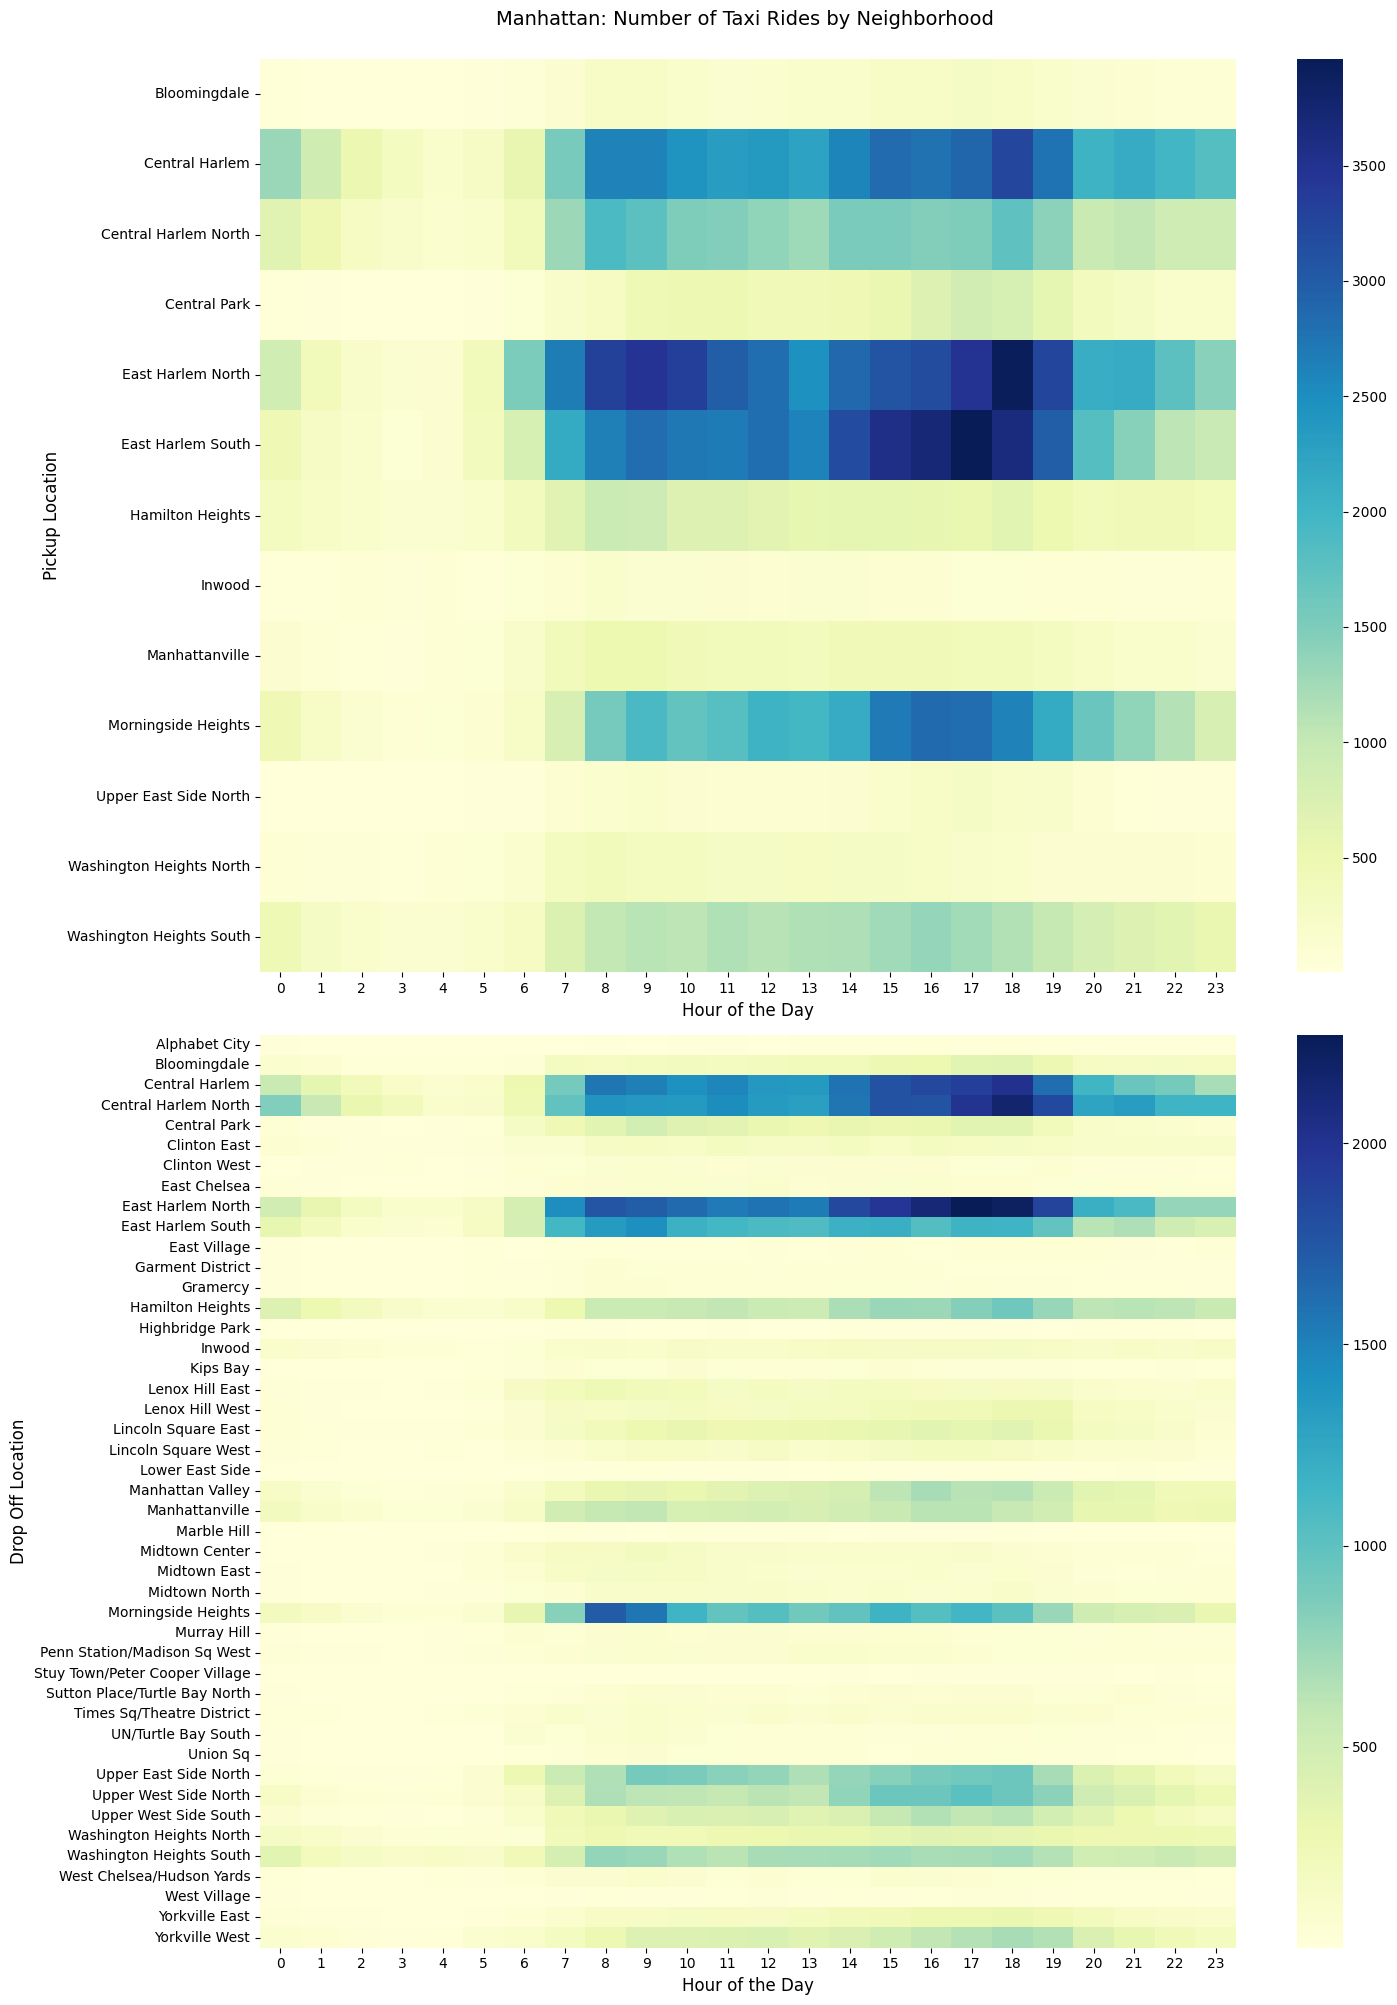

In [326]:
# Analyze travel around Manhattan
manhattan_df = mapped_boroughs.loc[mapped_boroughs['map_diffBorough']=='Manhattan'].reset_index()
map_diffZone = []

for i in range(0, len(manhattan_df)):
    if(manhattan_df['puZone'][i]==manhattan_df['doZone'][i]):
        map_diffZone.append(manhattan_df['puZone'][i])
    else:
        map_diffZone.append(manhattan_df['puZone'][i] + " to " + manhattan_df['doZone'][i])
        
manhattan_df['zone_map'] = map_diffZone

# Focus on most popular rides
manhattan_zone_df = manhattan_df.groupby(['zone_map', 'hour']).size().unstack().dropna()

# Pickup location
manhattan_zone_pu_df = manhattan_df.groupby(['puZone', 'hour']).size().unstack().dropna()

# Drop off location
manhattan_zone_do_df = manhattan_df.groupby(['doZone', 'hour']).size().unstack().dropna()

# Plot heatmap of pickup location
plt.figure(figsize=(15,20))

plt.subplot(2, 1, 1)
sns.heatmap(manhattan_zone_pu_df, cmap='YlGnBu', annot=False).set(xlabel=None)
plt.ylabel('Pickup Location', size=12)
plt.xlabel('Hour of the Day', size=12)

plt.subplot(2, 1, 2)
sns.heatmap(manhattan_zone_do_df, cmap='YlGnBu', annot=False).set(xlabel=None)
plt.ylabel('Drop Off Location', size=12)
plt.xlabel('Hour of the Day', size=12)

plt.suptitle('Manhattan: Number of Taxi Rides by Neighborhood', y=1, fontsize=14)
plt.tight_layout()
plt.show()

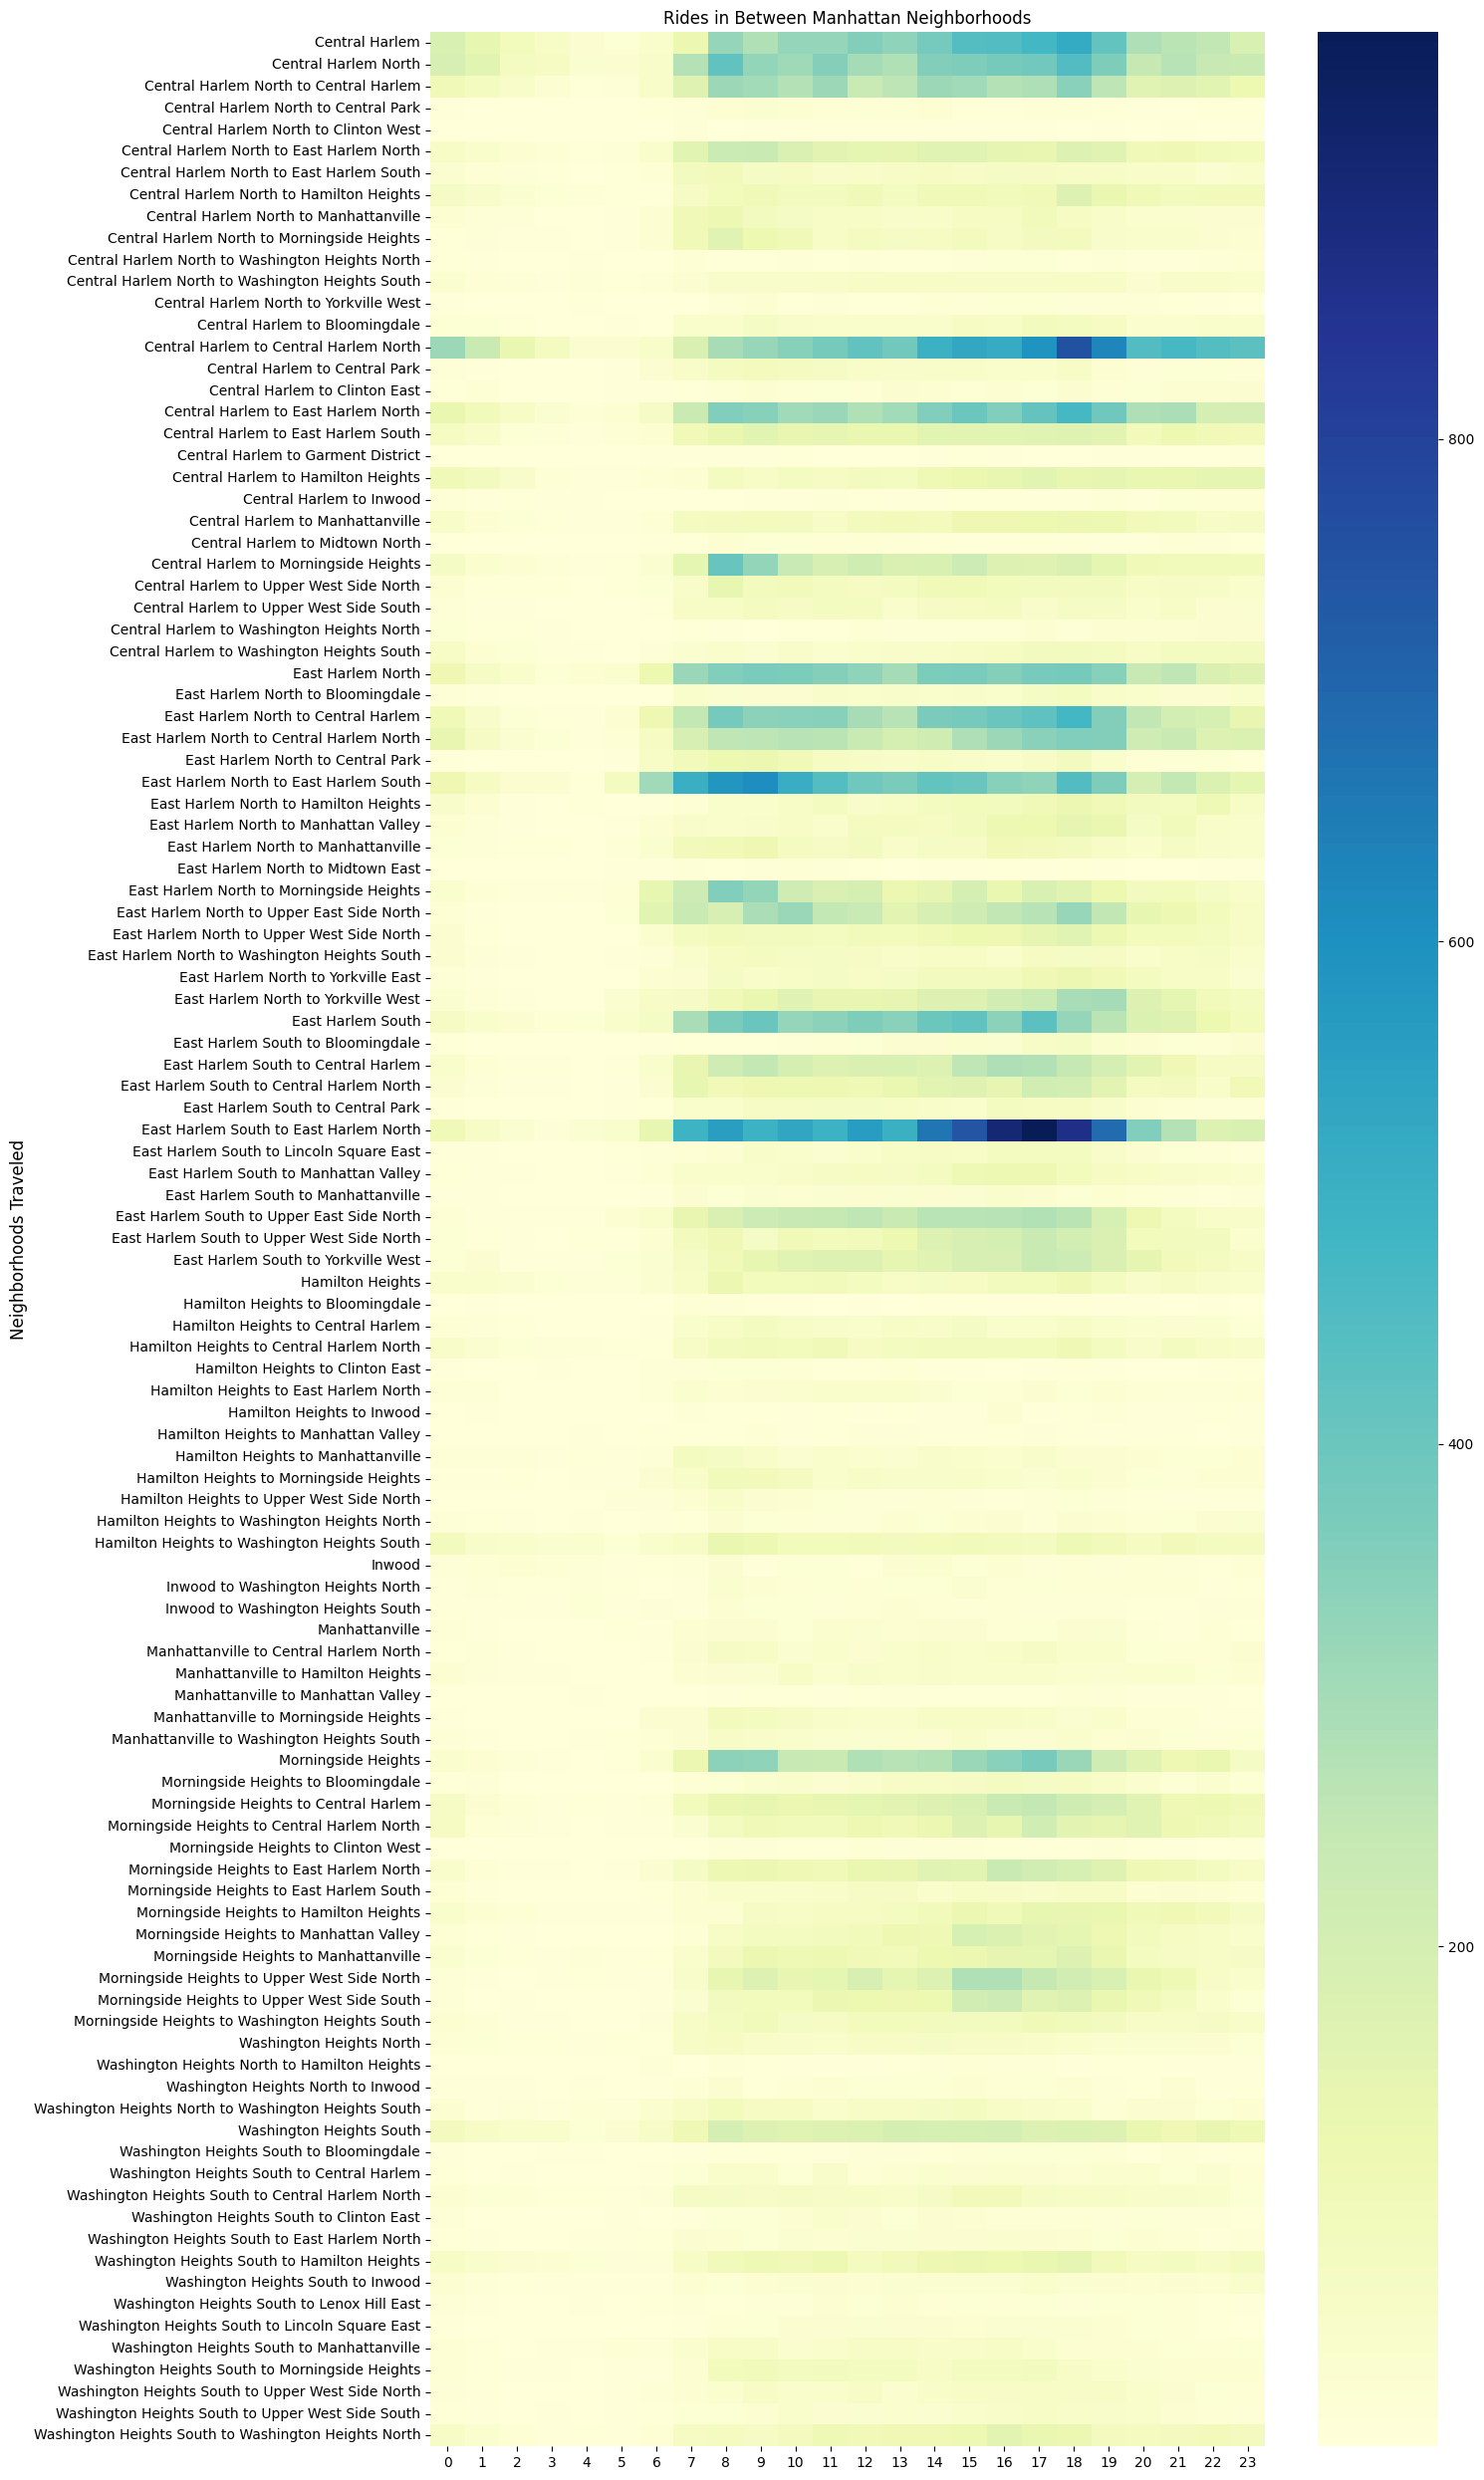

In [327]:
plt.figure(figsize=(15,25))

sns.heatmap(manhattan_zone_df, cmap='YlGnBu', annot=False).set(xlabel=None)
plt.ylabel('Neighborhoods Traveled', size=12)
plt.title('Rides in Between Manhattan Neighborhoods', size=12)

plt.tight_layout()
plt.show()

**Discussion of Analysis** In Manhattan, the most traveled trip between zones is East Harlem South to East Harlem North with most rides occuring between 7 and 21 hours. The zones in Manhattan that are popular for pickups and drop offs are around Harlem, the most popular being (East Harlem North and East Harlem South).

### Additional Analysis of Popular Pickup Boroughs

In [155]:
# Zone Use Analysis
puZ_loc_df = zone_loc_df.groupby(['puZone', 'puBorough']).size().unstack()

puZ_Bronx = puZ_loc_df[['Bronx']].dropna(0)
puZ_Brooklyn = puZ_loc_df[['Brooklyn']].dropna(0)
puZ_EWR = puZ_loc_df[['EWR']].dropna(0) # not useful for bar chart comparison
puZ_Manhattan = puZ_loc_df[['Manhattan']].dropna(0)
puZ_Queens = puZ_loc_df[['Queens']].dropna(0)
puZ_StatenIsland = puZ_loc_df[['Staten Island']].dropna(0) # not useful for bar chart comparison

puZ_Bronx = puZ_Bronx.loc[puZ_Bronx['Bronx'] >=1000]
puZ_Brooklyn = puZ_Brooklyn.loc[puZ_Brooklyn['Brooklyn'] >=1000]
puZ_Manhattan = puZ_Manhattan.loc[puZ_Manhattan['Manhattan'] >=1000]
puZ_Queens = puZ_Queens.loc[puZ_Queens['Queens'] >=1000]

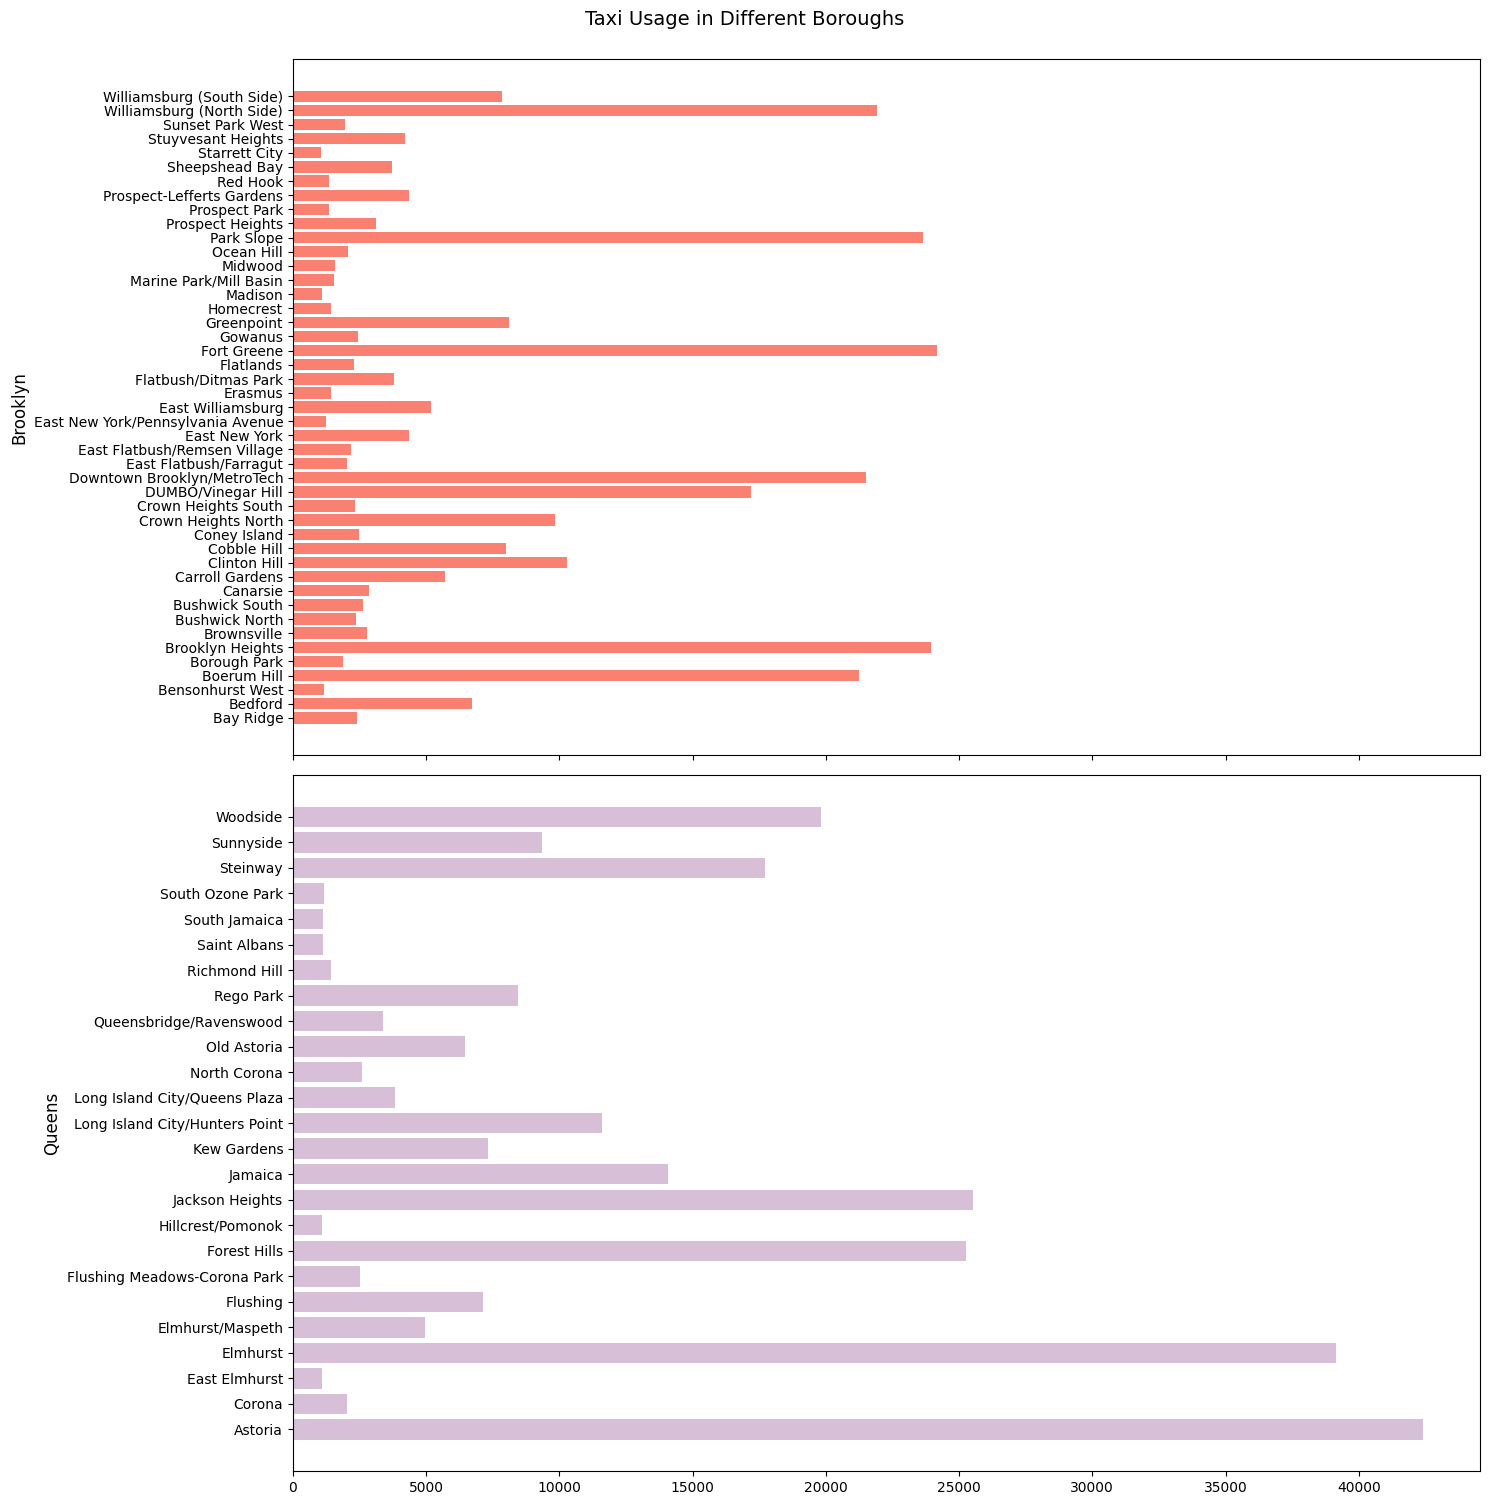

In [323]:
# Plot heatmap of pickup location
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,30))
fig, (ax2, ax4) = plt.subplots(2, 1, sharex=True, figsize=(15,15))

#ax1.barh(puZ_Bronx.index.values, puZ_Bronx['Bronx'], color='skyblue')
#ax1.set_ylabel('Bronx')
#ax1.tick_params(axis='y', labelsize=8)

ax2.barh(puZ_Brooklyn.index.values, puZ_Brooklyn['Brooklyn'], color='salmon')
ax2.set_ylabel('Brooklyn', size=12)
ax2.tick_params(axis='y', labelsize=10)

#ax3.barh(puZ_Manhattan.index.values, puZ_Manhattan['Manhattan'], color='mediumseagreen')
#ax3.set_ylabel('Manhattan')
#ax3.tick_params(axis='y', labelsize=8)

ax4.barh(puZ_Queens.index.values, puZ_Queens['Queens'], color='thistle')
ax4.set_ylabel('Queens', size=12)
ax4.tick_params(axis='y', labelsize=10)

plt.suptitle("Taxi Usage in Different Boroughs", y=1, fontsize=14)
plt.tight_layout()
plt.show()

**Discussion of Analysis** In Brooklyn the most popular pickup locations are Brooklyn Heights, Fort Greene, and Park Slope. Queens has even more riders starting their trip from this borough than Brooklyn. The most popular pickup locations are Astoria and Elmhurst. 